In [193]:
# Основные библиотеки
import numpy as np
import pandas as pd

#Визуализация
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Разделение датасета на тренировочный и тестовый
from sklearn.model_selection import train_test_split, KFold

#Модели машинного обучения
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score

#Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

#Отключим лишние предупреждения
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

# Загрузка данных

In [194]:
TEST_DATA_PATH = 'test.csv'
TRAIN_DATA_PATH = 'train.csv'
test_df = pd.read_csv(TEST_DATA_PATH, sep=',')
train_df = pd.read_csv(TRAIN_DATA_PATH, sep=',')


Цель - предсказать стоимость дома<br>

Описание датасета:<br>

<b>Id</b> - идентификационный номер квартиры<br>
<b>DistrictId</b> - идентификационный номер района<br>
<b>Rooms</b> - количество комнат<br>
<b>Square</b> - площадь<br>
<b>LifeSquare</b> - жилая площадь<br>
<b>KitchenSquare</b> - площадь кухни<br>
<b>Floor</b> - этаж<br>
<b>HouseFloor</b> - количество этажей в доме<br>
<b>HouseYear</b> - год постройки дома<br>
<b>Ecology_1, Ecology_2, Ecology_3</b> - экологические показатели местности<br>
<b>Social_1, Social_2, Social_3</b> - социальные показатели местности<br>
<b>Healthcare_1, Helthcare_2</b> - показатели местности, связанные с охраной здоровья<br>
<b>Shops_1, Shops_2</b> - показатели, связанные с наличием магазинов, торговых центров<br>
<b>Price</b> - цена квартиры<br>

# EDA: Визуализация данных

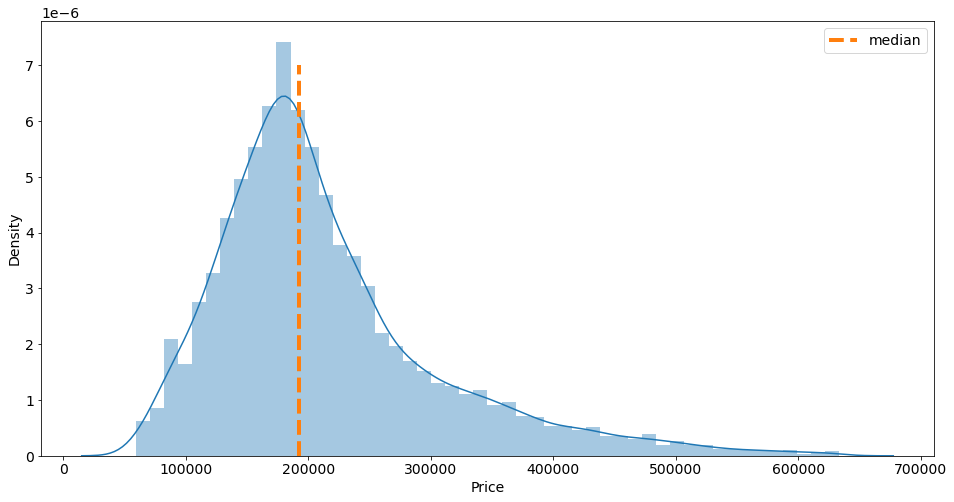

In [195]:
target_median = train_df['Price'].median()
y = np.linspace(0, 0.000007, 2)

plt.figure(figsize=(16, 8))
sns.distplot(train_df['Price'], bins=50) # hist + kdeplot
plt.plot([target_median] * 2, y, label='median', linewidth=4, linestyle='--')
plt.legend()
plt.show()

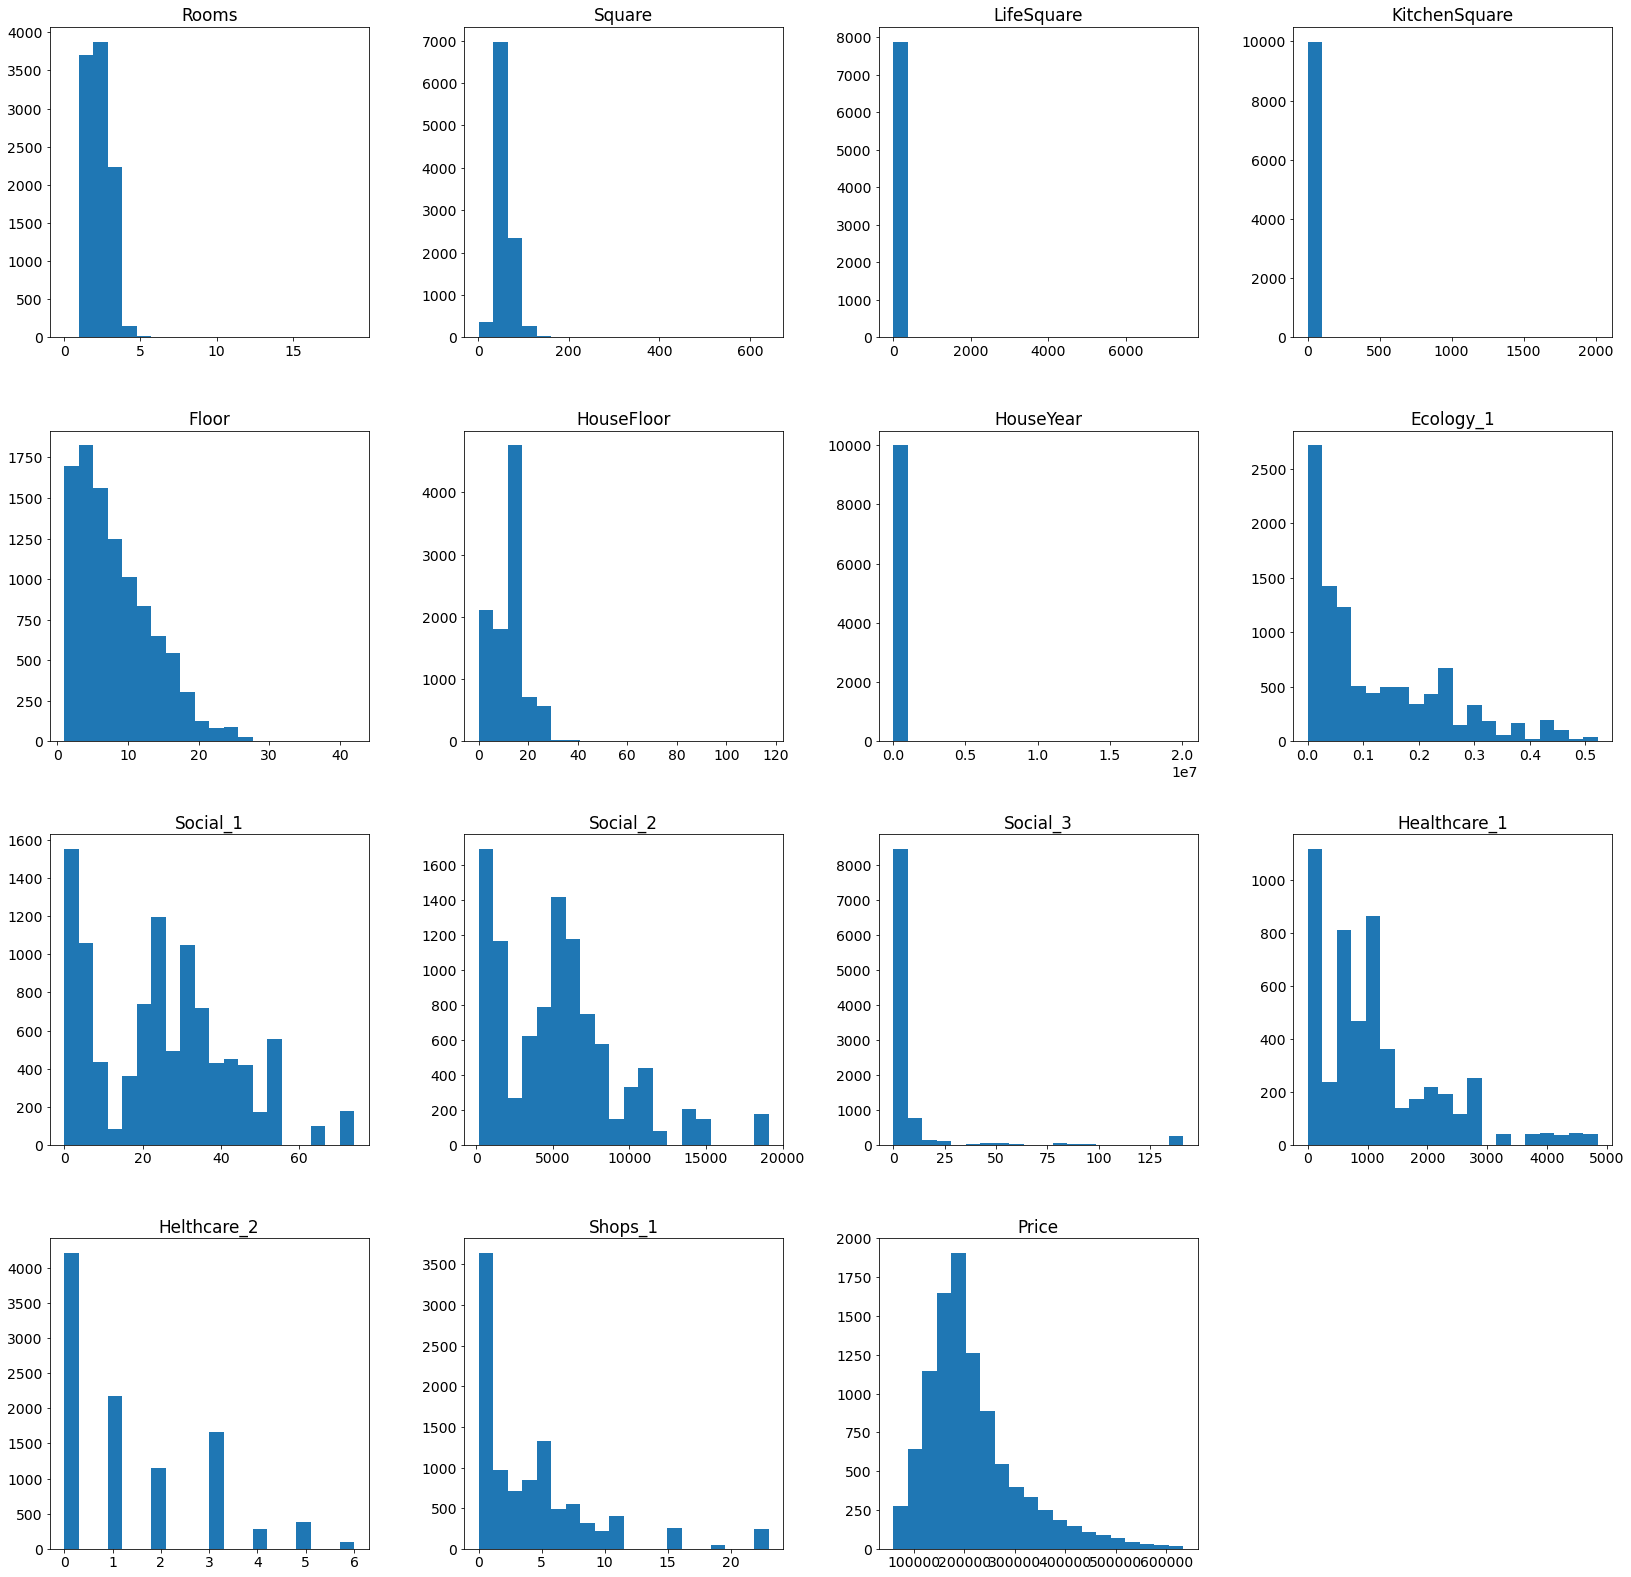

In [196]:
train_df_num_feature = train_df.select_dtypes(include=['int64', 'float64'])
train_df_num_feature.drop(['Id', 'DistrictId'], axis=1, inplace=True)

train_df_num_feature.hist(figsize=(28, 28), bins=20, grid=False)
plt.show()

<AxesSubplot:>

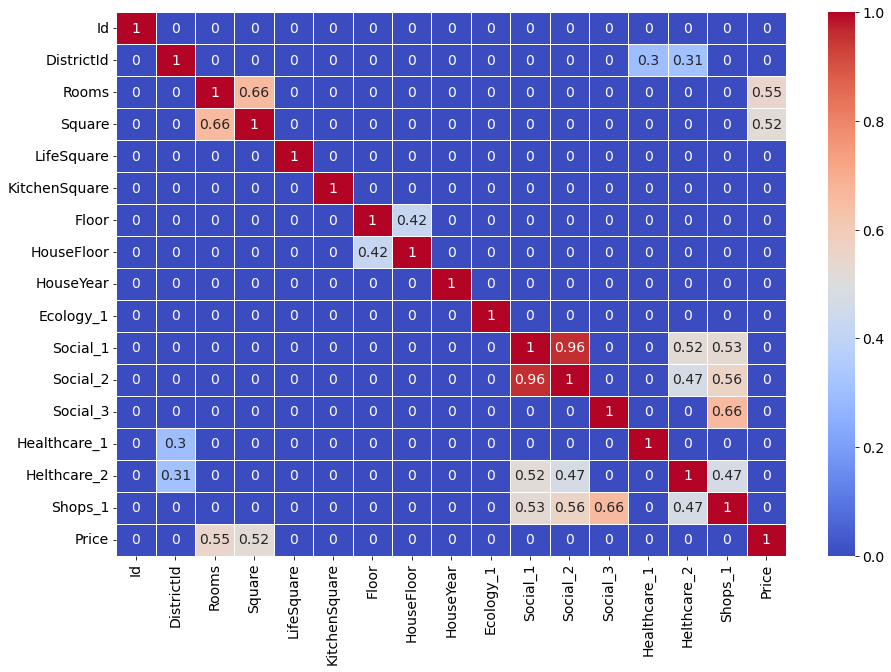

In [197]:
plt.figure(figsize=(15, 10))
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, cmap='coolwarm')

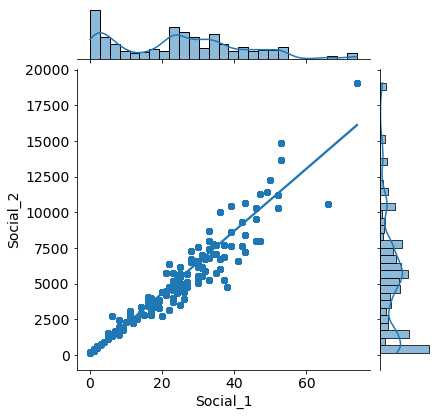

In [198]:
grid = sns.jointplot(train_df['Social_1'], train_df['Social_2'], kind='reg')

# Обработка выбросов

### Rooms

In [199]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

### Square

In [200]:
train_df.loc[train_df['Square'] < np.quantile(train_df['Square'], q=0.025), 'Square'] = train_df['Square'].median()
train_df.loc[train_df['Square'] > np.quantile(train_df['Square'], q=0.975), 'Square'] = train_df['Square'].median()

### KitchenSquare

In [201]:
train_df.loc[(train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'].isna()), 'KitchenSquare'] = 3
train_df.loc[train_df['KitchenSquare'] > np.quantile(train_df['KitchenSquare'], q=0.975), 'KitchenSquare'] = train_df['KitchenSquare'].median()

### HouseFloor

In [202]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

### HouseYear

In [203]:
train_df.loc[train_df['HouseYear'] > 2022, 'HouseYear'] = 2022

### Healthcare_1

In [204]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

### LifeSquare

In [205]:
condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 3

In [206]:
train_df.loc[train_df['LifeSquare'] < np.quantile(train_df['LifeSquare'], q=0.03), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['LifeSquare'] > np.quantile(train_df['LifeSquare'], q=0.99), 'LifeSquare'] = train_df['LifeSquare'].median()

### Floor

In [207]:
train_df.loc[(train_df['HouseFloor'] == 1) & (train_df['Floor'] > train_df['HouseFloor']), 'Floor'] = 1

floor_index = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_index, 'Floor'] = train_df.loc[floor_index, 'HouseFloor'].apply(lambda x: random.randint(1, x))

# Создание класса для обработки данных

In [208]:
class DataPreprocessing:
    def __init__(self):
        
        self.medians = None
        self.square_quantile_025 = None
        self.square_quantile_975 = None
        self.kitchen_square_quantile_975 = None
        self.life_square_quantile_03 = None
        self.life_square_quantile_99 = None
    
    def fit(self, df):
        
        self.medians = df.median()
        self.square_quantile_025 = np.quantile(df['Square'], q=0.025)
        self.square_quantile_975 = np.quantile(df['Square'], q=0.975)
        self.kitchen_square_quantile_975 = np.quantile(df['KitchenSquare'], q=0.975)
        self.life_square_quantile_03 = np.quantile(df['LifeSquare'], q=0.03)
        self.life_square_quantile_99 = np.quantile(df['LifeSquare'], q=0.99)
    
    def transform(self, df):
        
        #rooms
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        #square
        df.loc[df['Square'] < self.square_quantile_025, 'Square'] = self.medians['Square']
        df.loc[df['Square'] > self.square_quantile_975, 'Square'] = self.medians['Square']
        
        #kitchensquare
        df.loc[(df['KitchenSquare'] < 3) | (df['KitchenSquare'].isna()), 'KitchenSquare'] = 3
        df.loc[df['KitchenSquare'] > self.kitchen_square_quantile_975, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        #housefloor
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        #houseyear
        df.loc[df['HouseYear'] > 2022] = 2022
        
        #healthcare_1
        if 'Healthcare_1' in df.columns:
            df.drop('Healthcare_1', axis=1, inplace=True)
        
        #lifesquare
        condition = (df['LifeSquare'].isna()) & (~df['Square'].isna()) & (~df['KitchenSquare'].isna())
        df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] - df.loc[condition, 'KitchenSquare'] - 3
        df.loc[df['LifeSquare'] < self.life_square_quantile_03, 'LifeSquare'] = self.medians['LifeSquare']
        df.loc[df['LifeSquare'] > self.life_square_quantile_99, 'LifeSquare'] = self.medians['LifeSquare']
        
        #floor
        df.loc[(df['HouseFloor'] == 1) & (df['Floor'] > df['HouseFloor']), 'Floor'] = 1
        floor_index = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_index, 'Floor'] = df.loc[floor_index, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        #other
        df.fillna(self.medians, inplace=True)
        
        return df
        

# Бинарное кодирование

In [209]:
bin_code = {'A': 0, 'B': 1}
object_col = train_df.select_dtypes(include=['object'])

for col_name in object_col:
    train_df[col_name] = train_df[col_name].replace(bin_code)

# Создание класса для новых фичей

In [210]:
class FeatureGenerator():
    
    def __init__(self):
        self.bin_code = None
        
    def fit(self, df, y=None):
        df = df.copy()
        self.bin_code = {'A': 0, 'B': 1}
       
    def transform(self, df):
        df['Ecology_2'] = df['Ecology_2'].replace(self.bin_code)
        df['Ecology_3'] = df['Ecology_3'].replace(self.bin_code)
        df['Shops_2'] = df['Shops_2'].replace(self.bin_code)
        
        return df

# Разбиение данных на train и test

In [211]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)

X = train_df.drop(columns='Price')
y = train_df['Price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=10)

In [212]:
data_treatment = DataPreprocessing()
data_treatment.fit(X_train)

X_train = data_treatment.transform(X_train)
X_valid = data_treatment.transform(X_valid)
test_df = data_treatment.transform(test_df)

feature_gen = FeatureGenerator()
feature_gen.fit(X_train, y_train)

X_train = feature_gen.transform(X_train)
X_valid = feature_gen.transform(X_valid)
test_df = feature_gen.transform(test_df)

# Обучение модели

In [213]:
forest_regress = RandomForestRegressor(random_state=45, criterion='mse')
forest_regress.fit(X_train, y_train)

RandomForestRegressor(random_state=45)

In [214]:
y_trains_predicts = forest_regress.predict(X_train)
y_tests_predicts = forest_regress.predict(X_valid)

# Оценка модели

In [215]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

In [216]:
evaluate_preds(y_train, y_trains_predicts, y_valid, y_tests_predicts)

Train R2:	0.956
Test R2:	0.732


In [217]:
cv_score = cross_val_score(forest_regress, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score.mean()

0.6737480503216536

# Прогнозирование

In [218]:
sample_submission = pd.read_csv('sample_submission.csv', sep=',')
result_pred = forest_regress.predict(test_df)
sample_submission['Price'] = result_pred
sample_submission.to_csv('result.csv', index=False)